In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack
import glob, os

In [2]:
from alexmods import read_data as rd
from alexmods import plot_abundances as pltabund

In [3]:
fnames = np.sort(glob.glob("outputs/*abunds.txt"))
print(len(fnames))

1


In [4]:
stars = [os.path.basename(x).split("_")[0] for x in fnames]

In [5]:
len(fnames), len(stars), len(np.unique(stars))

(1, 1, 1)

In [6]:
tabs = [Table.read(fn, format='ascii') for fn in fnames]
for t in tabs: t["star"] = t["star"].astype(str)

In [7]:
bigtab = vstack(tabs)

In [8]:
all_species = np.array(np.unique(bigtab["species"]))
all_species = all_species[all_species != 26.0]
all_species

array([ 8. , 11. , 12. , 13. , 14. , 19. , 20. , 21.1, 22. , 22.1, 24. ,
       24.1, 25. , 26.1, 27. , 28. , 30. , 38.1, 56.1, 63.1])

In [9]:
XFecols = [rd.make_XFecol(round(species,1)) for species in all_species]

In [10]:
errcols = [rd.make_errcol(x) for x in all_species]
allcols = ["star","[Fe/H]"]+XFecols+["e_fe"]+errcols
allcols

['star',
 '[Fe/H]',
 '[O/Fe]',
 '[Na/Fe]',
 '[Mg/Fe]',
 '[Al/Fe]',
 '[Si/Fe]',
 '[K/Fe]',
 '[Ca/Fe]',
 '[Sc/Fe]',
 '[Ti I/Fe]',
 '[Ti/Fe]',
 '[Cr/Fe]',
 '[Cr II/Fe]',
 '[Mn/Fe]',
 '[Fe II/Fe]',
 '[Co/Fe]',
 '[Ni/Fe]',
 '[Zn/Fe]',
 '[Sr/Fe]',
 '[Ba/Fe]',
 '[Eu/Fe]',
 'e_fe',
 'e_o',
 'e_na',
 'e_mg',
 'e_al',
 'e_si',
 'e_k',
 'e_ca',
 'e_sc',
 'e_ti1',
 'e_ti',
 'e_cr',
 'e_cr2',
 'e_mn',
 'e_fe2',
 'e_co',
 'e_ni',
 'e_zn',
 'e_sr',
 'e_ba',
 'e_eu']

In [11]:
np.array(tabs[0].colnames)

array(['species', 'elem', 'N', 'logeps', 'sigma', 'stderr', '[X/H]',
       '[X/Fe1]', '[X/Fe2]', '[X/Fe]', 'star'], dtype='<U7')

In [12]:
rows = []
for star, tab in zip(stars, tabs):
    try:
        ixfe = np.where(tab["species"]==26.0)[0][0]
    except:
        print(star,np.array(np.unique(tab["species"])))
        continue
    abunds = [tab["[X/H]"][ixfe]]
    errs = [tab["sigma"][ixfe]]
    for species in all_species:
        try:
            ix = np.where(tab["species"]==species)[0][0]
            xfe = tab["[X/Fe1]"][ix]
            err = tab["sigma"][ix]
        except:
            xfe = err = np.nan
        abunds.append(xfe)
        errs.append(err)
    row = [star] + abunds + errs
    rows.append(row)
abtab = Table(rows=rows, names=allcols)

In [13]:
abtab

star,[Fe/H],[O/Fe],[Na/Fe],[Mg/Fe],[Al/Fe],[Si/Fe],[K/Fe],[Ca/Fe],[Sc/Fe],[Ti I/Fe],[Ti/Fe],[Cr/Fe],[Cr II/Fe],[Mn/Fe],[Fe II/Fe],[Co/Fe],[Ni/Fe],[Zn/Fe],[Sr/Fe],[Ba/Fe],[Eu/Fe],e_fe,e_o,e_na,e_mg,e_al,e_si,e_k,e_ca,e_sc,e_ti1,e_ti,e_cr,e_cr2,e_mn,e_fe2,e_co,e_ni,e_zn,e_sr,e_ba,e_eu
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
hd122563,-2.71,1.56,0.36,0.3,-0.79,0.76,0.52,0.23,0.23,0.07,0.43,-0.32,-0.0,-0.31,0.17,0.32,0.16,0.22,-0.03,-0.65,-0.4,0.19,0.0,0.01,0.16,0.0,0.23,0.0,0.09,0.08,0.11,0.08,0.06,0.1,0.12,0.03,0.05,0.08,0.0,0.04,0.15,0.0


In [14]:
df = abtab.to_pandas()

In [15]:
df[["star","[Fe/H]","[Na/Fe]","[Mg/Fe]","[Ca/Fe]","[Sr/Fe]","[Ba/Fe]","e_mg"]]

,star,[Fe/H],[Na/Fe],[Mg/Fe],[Ca/Fe],[Sr/Fe],[Ba/Fe],e_mg
0,hd122563,-2.71,0.36,0.3,0.23,-0.03,-0.65,0.16


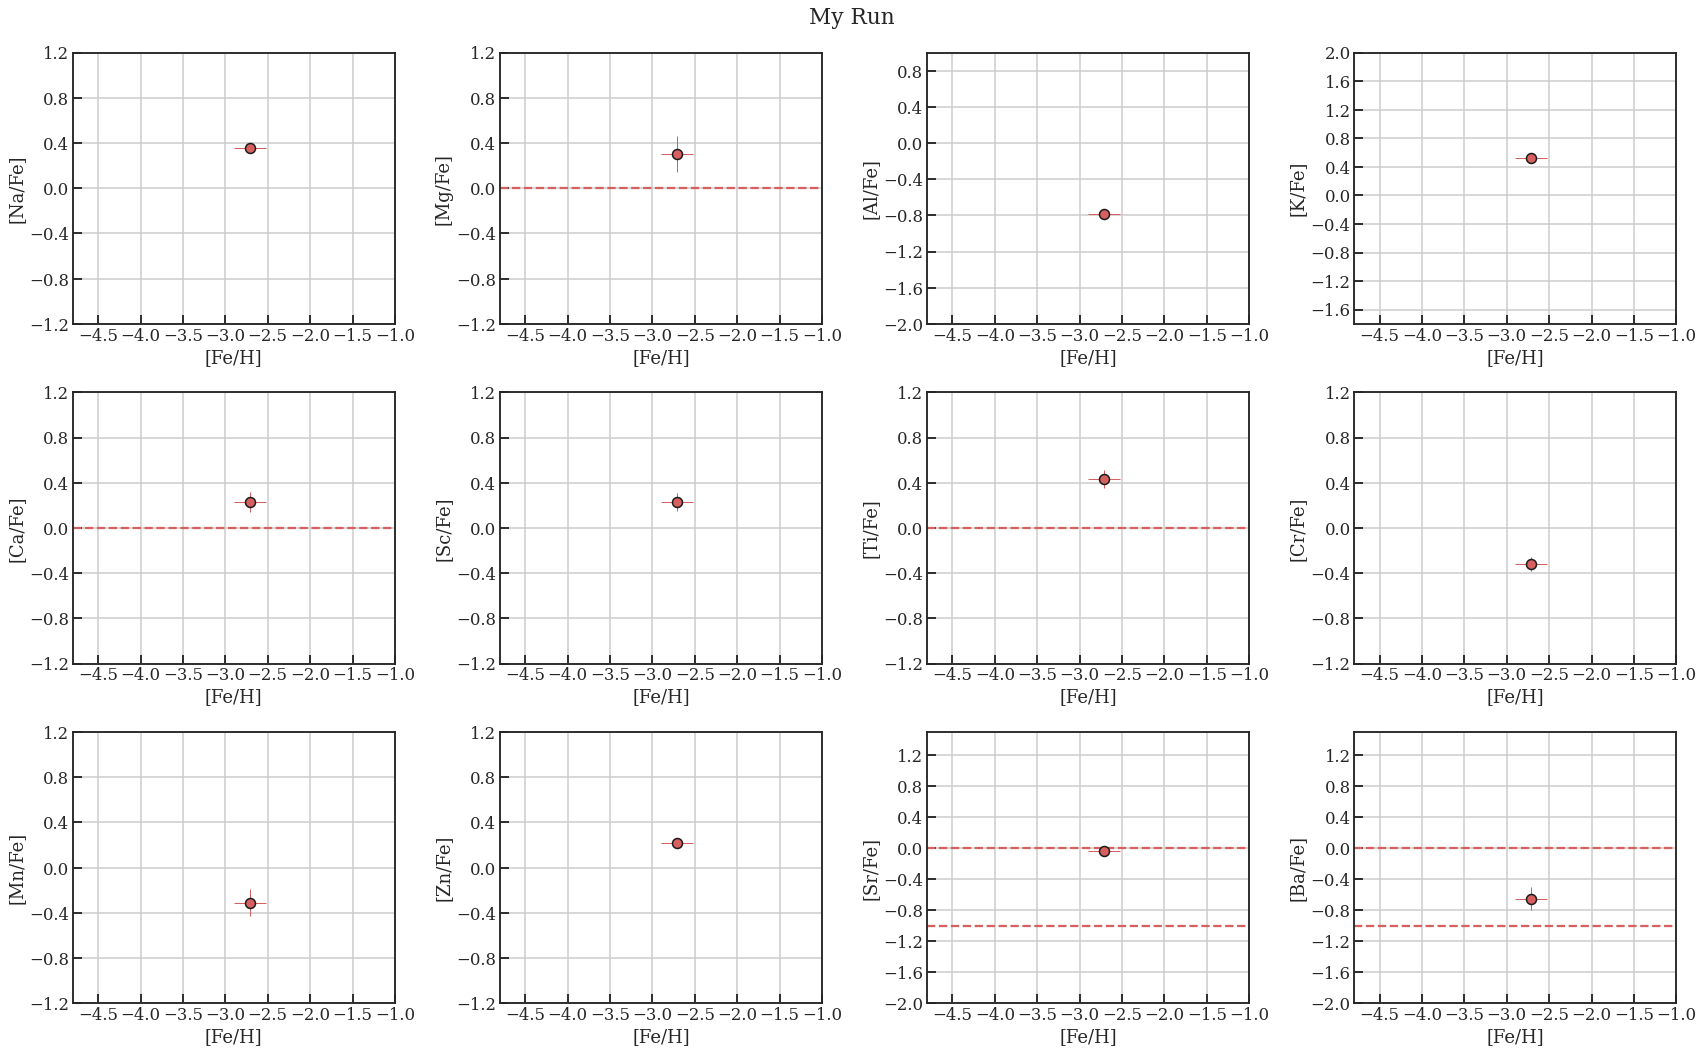

In [16]:
kws = pltabund.construct_dictionaries('r', 'o', 100)
kws["zorder"] = 100
elems = [["Na","Mg","Al","K"],["Ca","Sc","Ti","Cr"],["Mn","Zn","Sr","Ba"]]
ylim_dict = {
    "Al": (-2, 1.0),
    "K":  (-1.8, 2.0),
    "Sr": (-2, 1.5),
    "Ba": (-2, 1.5),
}
Nrow = len(elems)
Ncol = len(elems[0])

fig, axes = plt.subplots(Nrow, Ncol, figsize=(6*Ncol,5*Nrow))
for irow in range(Nrow):
    for icol in range(Ncol):
        ax = axes[irow,icol]
        elem = elems[irow][icol]
        pltabund.plot_XH_XFe(ax, "Fe", elem, df, plot_xerr=True, plot_yerr=True, **kws)
        #ylim = ax.get_ylim()
        ax.set(xlim=(-4.8,-1), ylabel=f"[{elem}/Fe]", xlabel="[Fe/H]")
        # try: ax.set(ylim=ylim_dict[elem])
        # except: pass
        ax.grid()
        if elem in ylim_dict:
            ax.set(ylim=ylim_dict[elem])
        else:
            ax.set_ylim(-1.2,1.2)
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.4))
        if elem in ["Sr","Ba"]:
            ax.axhline(-1, ls='--', color='r')
        if elem in ["Sr","Ba","Mg","Ca","Ti"]:
            ax.axhline(0, ls='--', color='r')
fig.suptitle("My Run")
fig.tight_layout()
